In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.9 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=2000): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Toronto photos', max_images=1)
urls[0]

'https://4kwallpapers.com/images/wallpapers/toronto-skyline-skyscrapers-canada-cityscape-night-lights-1280x800-2118.jpg'

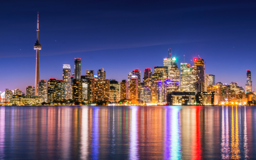

In [5]:
from fastdownload import download_url
dest = 'toronto.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

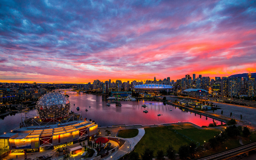

In [6]:
download_url(search_images('Vancouver photos', max_images=1)[0], 'vancouver.jpg', show_progress=False)
Image.open('vancouver.jpg').to_thumb(256,256)

In [7]:
searches = 'toronto','vancouver'
path = Path('toronto_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Step 2: Train our model

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

17

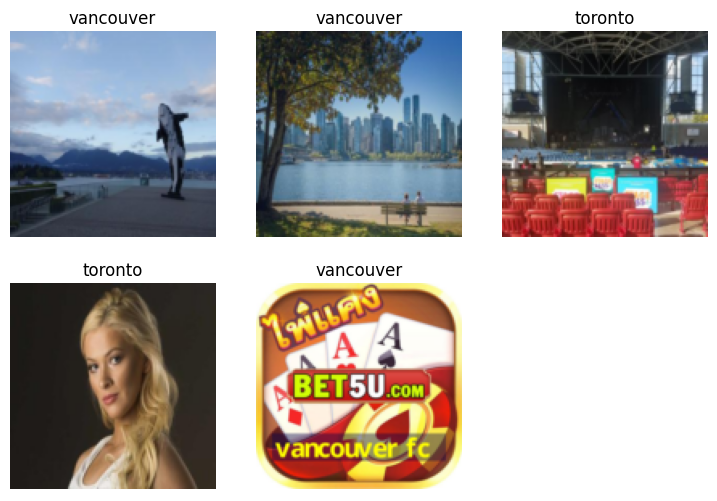

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=5)

In [10]:
learn = vision_learner(dls, efficientnet_b0, metrics=error_rate, pretrained=True)

from fastai.callback.tracker import EarlyStoppingCallback

learn.fit_one_cycle(10, lr_max=0.0012, 
                    cbs=EarlyStoppingCallback(monitor='valid_loss', patience=2))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 273MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.366576,0.685095,0.345865,00:12
1,1.107813,0.921138,0.330827,00:13
2,0.903304,0.997760,0.323308,00:13


No improvement since epoch 0: early stopping


In [11]:
learn.fine_tune(3, base_lr=0.0003)



epoch,train_loss,valid_loss,error_rate,time
0,0.571186,0.932728,0.338346,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.545216,0.900469,0.300752,00:18
1,0.466075,0.890423,0.300752,00:18
2,0.441920,0.892007,0.293233,00:17


In [12]:
is_toronto,_,probs = learn.predict(PILImage.create('toronto.jpg'))
print(f"This is: {is_toronto}.")
print(f"Probability it's Toronto: {probs[0]:.4f}")

This is: toronto.
Probability it's Toronto: 0.9974
